![Logo Recolto](https://recolto.netlify.app/assets/logo_recolto_blanc.png)

Ce notebook a pour objectif de comparer l’exactitude spatiale des points assignés aux deux grilles (SAFRAN - GeoJSON).

Auteur: Pierrick BERTHE

Source : https://www.data.gouv.fr/en/datasets/donnees-changement-climatique-sim-quotidienne/

# <span style='background:grey'>Importations des librairies</span>

In [1]:
# General imports
import sys
from datetime import datetime
import time
import os

# Geographical imports
import geopandas as gpd
import contextily as ctx

# Data manipulation imports
import pandas as pd
import matplotlib as mlp
import matplotlib.pyplot as plt

# Versions
print("Interpréteur python :")
print("Python        : " + sys.version + "\n")
print("Version des librairies utilisées :")
print("Geopandas    : " + gpd.__version__)
print("Matplotlib   : " + mlp.__version__)
print("Pandas       : " + pd.__version__)

# Afficher heure lancement
maintenant = datetime.now().isoformat()
print("\nCode lance le : " + maintenant)

# Enregistrer l'heure de debut
start_time = time.time()

# Vérifiez le répertoire de travail actuel
print("\nCurrent working directory:", os.getcwd())

Interpréteur python :
Python        : 3.12.5 (tags/v3.12.5:ff3bc82, Aug  6 2024, 20:45:27) [MSC v.1940 64 bit (AMD64)]

Version des librairies utilisées :
Geopandas    : 1.0.1
Matplotlib   : 3.10.0
Pandas       : 2.2.3

Code lance le : 2025-02-14T13:16:20.766454

Current working directory: c:\Users\pierr\VSC_Projects\Recolto\scripts


# <span style='background:grey'>Importation des données</span>

Nous chargeons les données de SAFRAN et de GeoJSON.

In [2]:
# path to JSON File
if os.getcwd().endswith("scripts"):
    folder_path = "../public/data"
    os.chdir(folder_path)
    print("New working directory:", os.getcwd())
else:
    pass
    print("Current working directory:", os.getcwd())

# Define the filenames
grid_safran_filename = "coordonnees_grille_safran_lambert-2-etendu.csv"
grid_geojson_filename = "centroid_coordinates_SIM_LON_LAT.json"

# Load the files
grid_safran_df = pd.read_csv(grid_safran_filename, sep=";")
grid_geojson_df = pd.read_json(grid_geojson_filename)

New working directory: c:\Users\pierr\VSC_Projects\Recolto\public\data


# <span style='background:blue'>Etape 1 : Affichage des grilles</span>

Nous formatons les données de Safran pour ne garder que la longitude et la latitude.

In [3]:
# delete 2 col
grid_safran_df = grid_safran_df.drop(columns=["LAMBX (hm)", "LAMBY (hm)"])

# Rename columns
grid_safran_df = grid_safran_df.rename(
    columns={
        "LON_DG": "LON",
        "LAT_DG": "LAT"
    }
)

grid_safran_df["LON"] = grid_safran_df["LON"].str.replace(",", ".").astype(float)
grid_safran_df["LAT"] = grid_safran_df["LAT"].str.replace(",", ".").astype(float)

grid_safran_df = grid_safran_df[["LON", "LAT"]]

grid_safran_df.info()
print("\n")

display(grid_safran_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9892 entries, 0 to 9891
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   LON     9892 non-null   float64
 1   LAT     9892 non-null   float64
dtypes: float64(2)
memory usage: 154.7 KB




,LON,LAT
0,-4.96118,48.3822
1,-4.76561,48.5386
2,-4.75585,48.4670
3,-4.74612,48.3953
4,-4.73641,48.3237
...,...,...
9887,9.55634,42.3189
9888,9.54748,42.2473
9889,9.53863,42.1758
9890,9.52981,42.1043


idem pour GeoJSON.

In [4]:
grid_geojson_df = grid_geojson_df.drop(columns=["GID"])

display(grid_geojson_df)

,LON,LAT
0,-4.699,48.037
1,-4.747,48.395
2,-4.757,48.467
3,-4.592,48.043
4,-4.620,48.258
...,...,...
8591,9.477,42.469
8592,9.486,42.540
8593,9.529,42.104
8594,9.538,42.176


Nous affichons les deux grilles sur une carte.

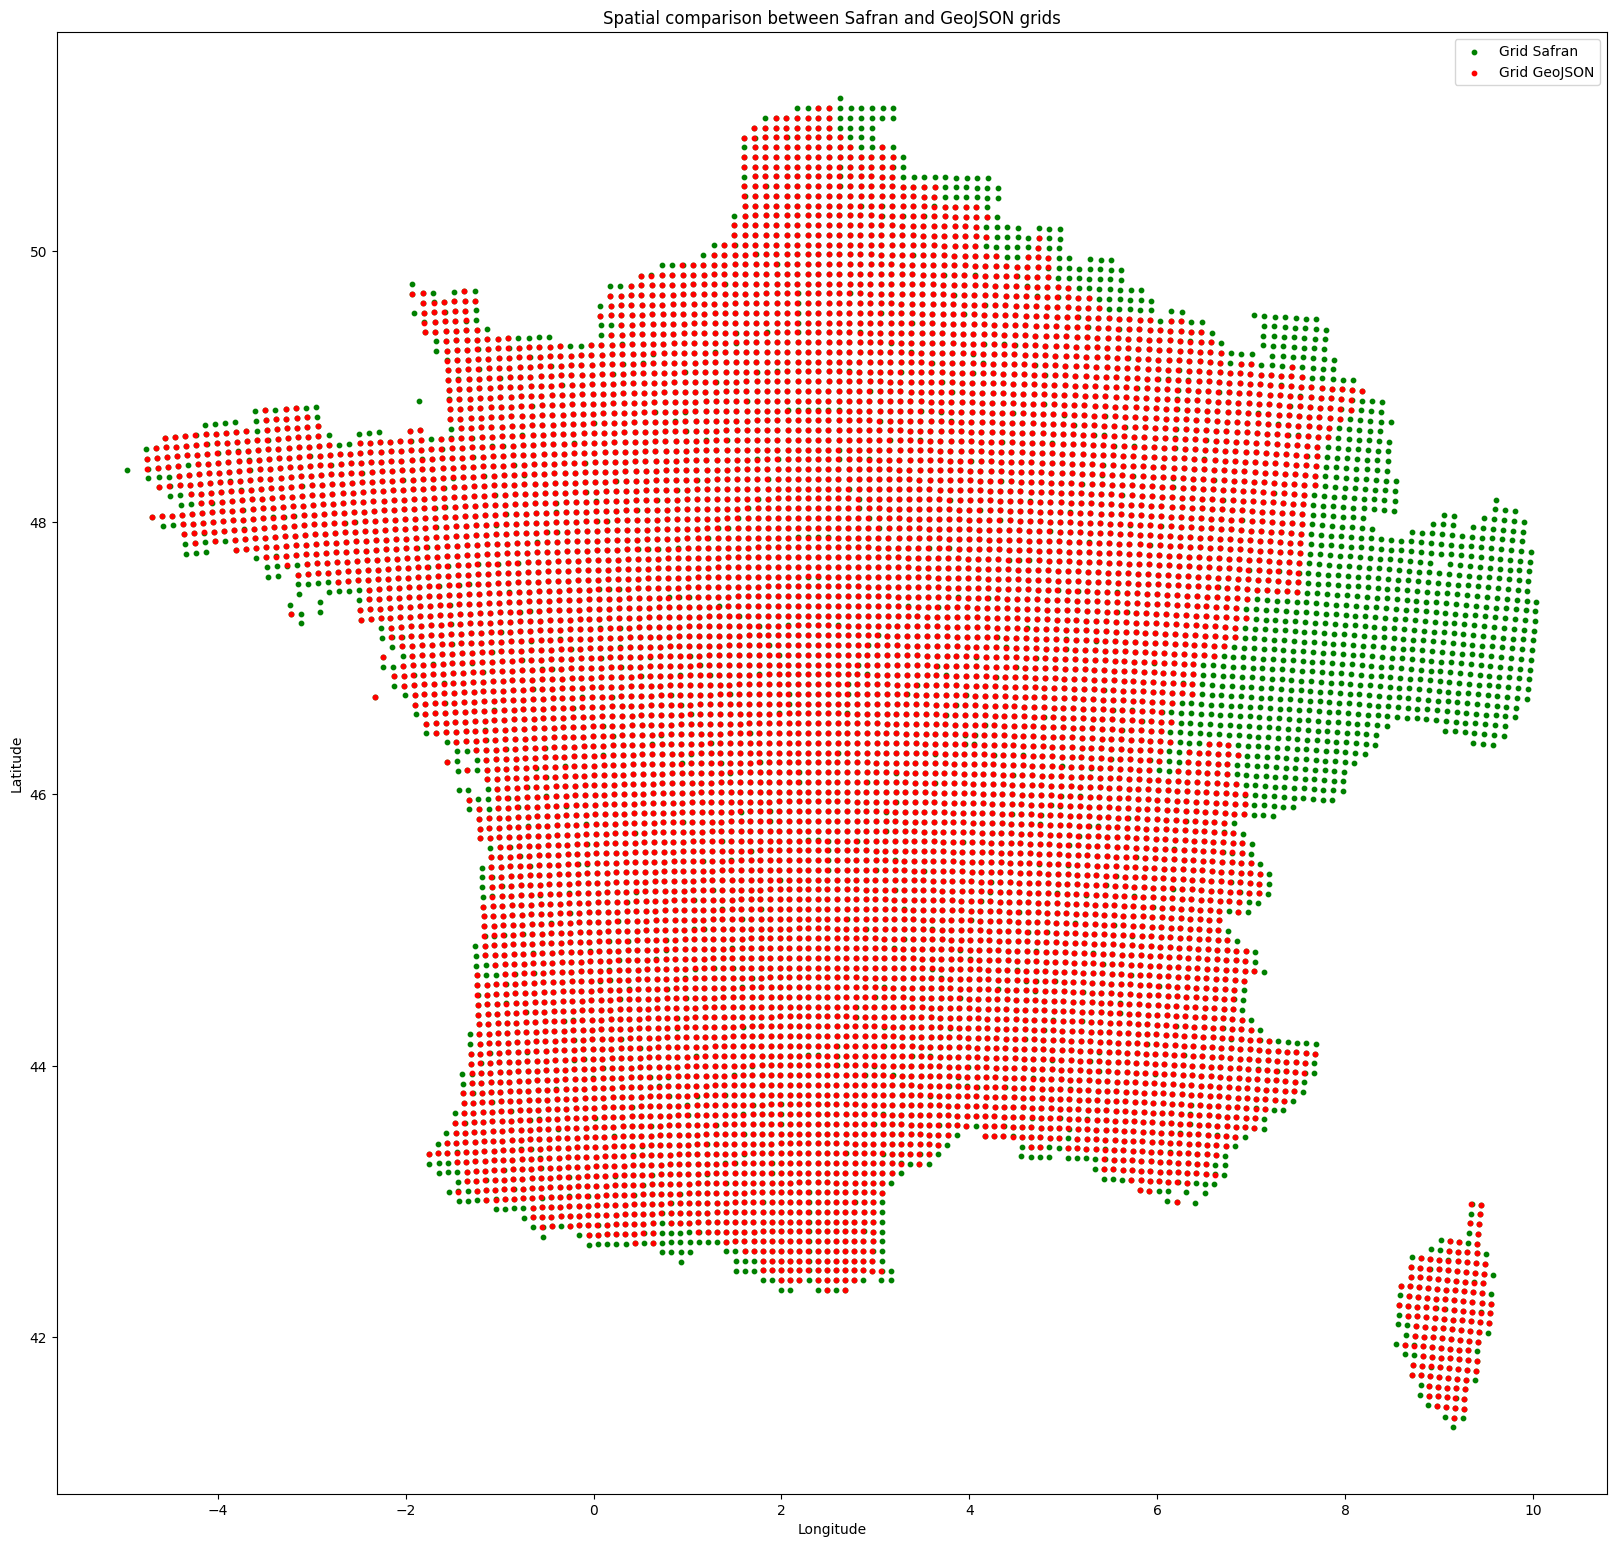

In [5]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(20, 20))

# Create a GeoDataFrame from a DataFrame with coordinates
grid_safran_gdf = gpd.GeoDataFrame(
    grid_safran_df,
    geometry=gpd.points_from_xy(grid_safran_df['LON'], grid_safran_df['LAT']),
    crs="EPSG:4326"
)

grid_geojson_gdf = gpd.GeoDataFrame(
    grid_geojson_df,
    geometry=gpd.points_from_xy(grid_geojson_df['LON'], grid_geojson_df['LAT']),
    crs="EPSG:4326"
)

# # Reproject the GeoDataFrames
# grid_safran_gdf = grid_safran_gdf.to_crs(epsg=3857)
# grid_geojson_gdf = grid_geojson_gdf.to_crs(epsg=3857)

# Plot the GeoDataFrames
grid_safran_gdf.plot(
    ax=ax,
    color='green',
    markersize=10,
    label="Grid Safran"
)

grid_geojson_gdf.plot(
    ax=ax,
    color='red',
    markersize=10,
    label="Grid GeoJSON"
)

# # Add a basemap
# ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=10)

# Add a title and legend
plt.legend()
plt.title("Spatial comparison between Safran and GeoJSON grids")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

# <span style='background:blue'>Etape 2 : Etude proximité des points</span>

Nous étudions la proportion de points de Safran qui sont à moins de 1km d'un point de GeoJSON.

In [6]:
import numpy as np
from scipy.spatial import distance_matrix

In [7]:
grid_safran_gdf = grid_safran_gdf.to_crs(epsg=3857)
grid_geojson_gdf = grid_geojson_gdf.to_crs(epsg=3857)

In [8]:
combined_gdf = pd.concat([grid_safran_gdf, grid_geojson_gdf])

In [ ]:
coords = np.array(
    list(combined_gdf.geometry.apply(lambda geom: (geom.x, geom.y)))
)

In [10]:
dist_matrix = distance_matrix(coords, coords)

In [11]:
threshold_distance = 1_000  # en mètres
close_pairs = np.sum((dist_matrix < threshold_distance) & (dist_matrix > 0))

# Diviser par 2 car chaque paire est comptée deux fois
close_pairs = close_pairs // 2

print(f"Nombre de paires de points à moins d'un kilomètre les uns des autres: {close_pairs}")

Nombre de paires de points à moins d'un kilomètre les uns des autres: 8596


In [12]:
close_points_indices = np.where((dist_matrix < threshold_distance) & (dist_matrix > 0))

In [13]:
unique_close_points_indices = np.unique(np.concatenate((close_points_indices[0], close_points_indices[1])))

In [14]:
close_points_gdf = combined_gdf.iloc[unique_close_points_indices]

<Axes: >

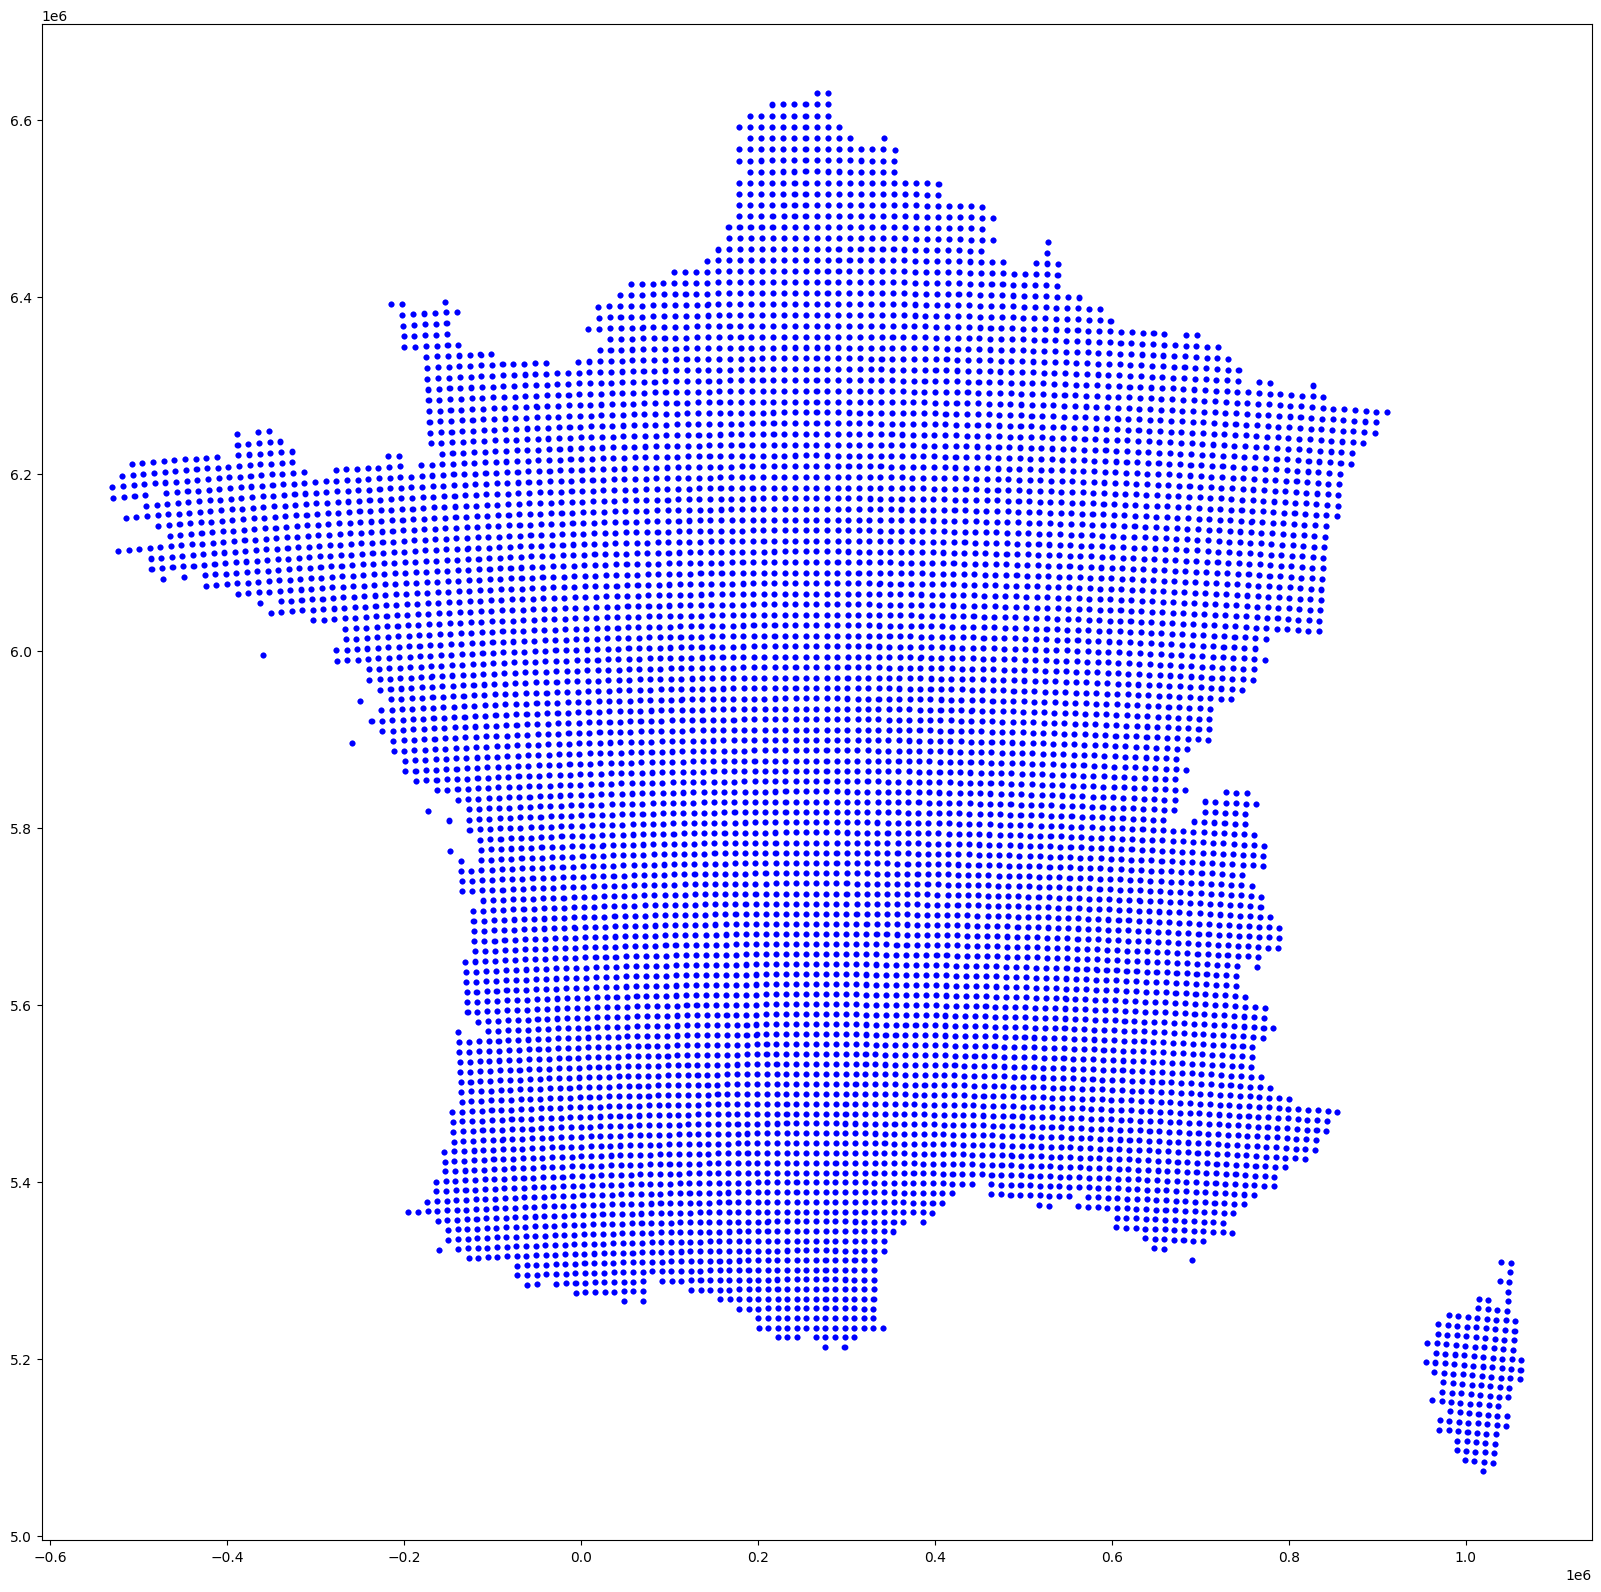

In [15]:
fig, ax = plt.subplots(figsize=(20, 20))
close_points_gdf.plot(ax=ax, color='blue', markersize=10, label="Points proches")